In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# **Data Loading**

In [29]:
df = pd.read_csv('insurance.csv')
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# **Data Exploration (EDA)**


In [30]:
print(df.isnull().sum())
print(df.describe())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


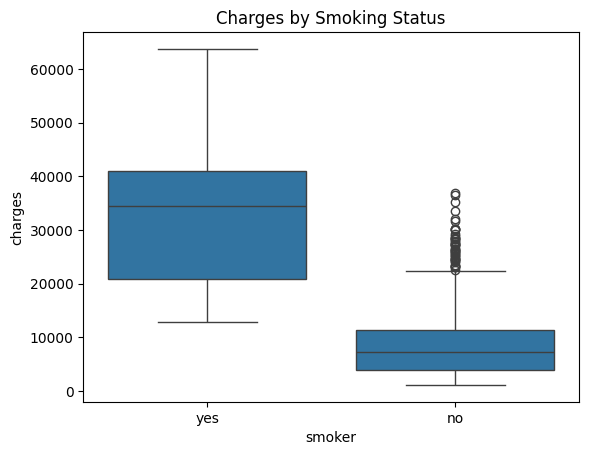

In [31]:
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by Smoking Status')
plt.show()


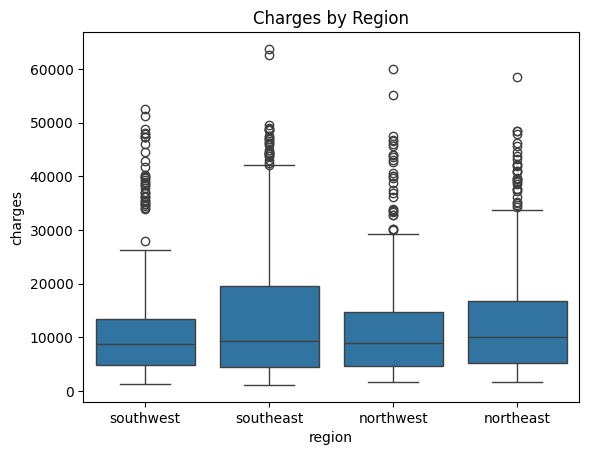

In [32]:
sns.boxplot(x='region', y='charges', data=df)
plt.title('Charges by Region')
plt.show()


## **Correlation Analysis**

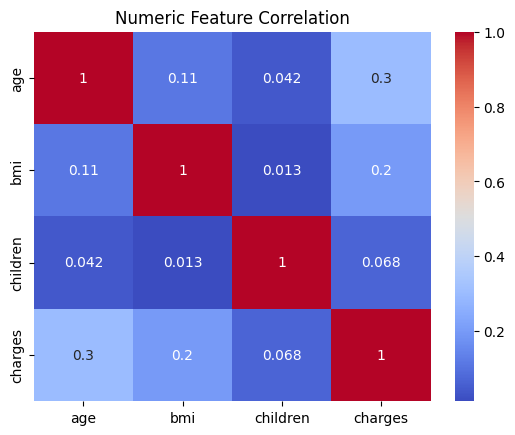

In [33]:
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Numeric Feature Correlation')
plt.show()


# **Feature Encoding**

In [34]:
# Keep original region for dashboard
df_encoded = df.copy()

# One-hot encode sex, smoker, region
df_encoded = pd.get_dummies(df_encoded, columns=['sex', 'smoker', 'region'], drop_first=True)


# **Train-Test Split**

In [35]:
# Features & Target
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Keep original region too
region_original = df['region']

# Split ALL at once
X_train, X_test, y_train, y_test, region_train, region_test = train_test_split(
    X, y, region_original, test_size=0.3, random_state=42
)

print(X_train.shape)


(936, 8)


# **Train Linear Regression Model**

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)


# **Evaluate Model Performance**

In [38]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("R2:", r2_score(y_test, y_pred))
print("RMSE:", rmse)


R2: 0.7696118054369011
RMSE: 5812.100272258871


In [39]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)


            Feature   Coefficient
4        smoker_yes  23628.367222
2          children    424.119128
1               bmi    348.906915
0               age    261.296924
3          sex_male    104.811823
5  region_northwest   -486.934610
7  region_southwest   -926.322908
6  region_southeast   -970.968839


# **Export Predictions for Power BI**

In [40]:
# Copy test set
X_test_copy = X_test.copy()

# Add Actual & Predicted
X_test_copy['Actual'] = y_test
X_test_copy['Predicted'] = y_pred

# Add back clean region
X_test_copy['Region'] = region_test

# OPTIONAL: drop dummy region columns if you prefer
X_test_copy = X_test_copy.drop(
    columns=[col for col in X_test_copy.columns if col.startswith('region_')]
)

# Export
X_test_copy.to_csv('insurance_predictions.csv', index=False)
